In [19]:
import matplotlib.pyplot as plt # for plotting
from matplotlib.ticker import MaxNLocator,AutoMinorLocator # for minor ticks
from lmfit.models import PolynomialModel, GaussianModel # for the signal and background fits
import pandas as pd
import numpy as np

In [20]:
def plot_data(data):
    lumi = 10
    fraction = 0.8

    xmin = 100 # GeV
    xmax = 160 # GeV
    step_size = 3 # GeV
    
    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    data_x,_ = np.histogram(data['myy'], 
                            bins=bin_edges ) # histogram the data
    data_x_errors = np.sqrt( data_x ) # statistical error on the data

    # data fit
    polynomial_mod = PolynomialModel( 4 ) # 4th order polynomial
    gaussian_mod = GaussianModel() # Gaussian
    
    # set initial guesses for the parameters of the polynomial model
    # c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
    pars = polynomial_mod.guess(data_x, # data to use to guess parameter values
                                x=bin_centres, c0=data_x.max(), c1=0,
                                c2=0, c3=0, c4=0 )
    
    # set initial guesses for the parameters of the Gaussian model
    pars += gaussian_mod.guess(data_x, # data to use to guess parameter values
                               x=bin_centres, amplitude=100, 
                               center=125, sigma=2 )
    
    model = polynomial_mod + gaussian_mod # combined model
    
    # fit the model to the data
    out = model.fit(data_x, # data to be fit
                    pars, # guesses for the parameters
                    x=bin_centres, weights=1/data_x_errors ) 

    # background part of fit
    params_dict = out.params.valuesdict() # get the parameters from the fit to data
    c0 = params_dict['c0'] # c0 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
    c1 = params_dict['c1'] # c1 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
    c2 = params_dict['c2'] # c2 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
    c3 = params_dict['c3'] # c3 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
    c4 = params_dict['c4'] # c4 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
    
    # get the background only part of the fit to data
    background = c0 + c1*bin_centres + c2*bin_centres**2 + c3*bin_centres**3 + c4*bin_centres**4

    # data fit - background fit = signal fit
    signal_x = data_x - background 


    # *************
    # Main plot 
    # *************
    plt.axes([0.1,0.3,0.85,0.65]) # left, bottom, width, height 
    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors, 
                       fmt='ko', # 'k' means black and 'o' means circles
                       label='Data' ) 
    
    # plot the signal + background fit
    main_axes.plot(bin_centres, # x
                   out.best_fit, # y
                   '-r', # single red line
                   label='Sig+Bkg Fit ($m_H=125$ GeV)' )
    
    # plot the background only fit
    main_axes.plot(bin_centres, # x
                   background, # y
                   '--r', # dashed red line
                   label='Bkg (4th order polynomial)' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x-axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          labelbottom=False, # don't draw tick labels on bottom axis
                          right=True ) # draw ticks on right axis
    
    # write y-axis label for main axes
    main_axes.set_ylabel('Events / '+str(step_size)+' GeV', 
                         horizontalalignment='right') 
    
    # set the y-axis limit for the main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.1 ) 
    
    # set minor ticks on the y-axis of the main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # avoid displaying y=0 on the main axes
    main_axes.yaxis.get_major_ticks()[0].set_visible(False) 

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.2, # x
             0.92, # y
             'ATLAS Open Data', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
    # Add text 'for education' on plot
    plt.text(0.2, # x
             0.86, # y
             'for education', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=8 ) 
    
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.2, # x
             0.8, # y
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes 
    
    # Add a label for the analysis carried out
    plt.text(0.2, # x
             0.74, # y
             r'$H \rightarrow \gamma\gamma$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    main_axes.legend(frameon=False, # no box around the legend
                     loc='lower left' ) # legend location 


    # *************
    # Data-Bkg plot 
    # *************
    plt.axes([0.1,0.1,0.85,0.2]) # left, bottom, width, height
    sub_axes = plt.gca() # get the current axes
    
    # set the y axis to be symmetric about Data-Background=0
    sub_axes.yaxis.set_major_locator( MaxNLocator(nbins='auto', 
                                                  symmetric=True) )
    
    # plot Data-Background
    sub_axes.errorbar(x=bin_centres, y=signal_x, yerr=data_x_errors,
                      fmt='ko' ) # 'k' means black and 'o' means circles
    
    # draw the fit to data
    sub_axes.plot(bin_centres, # x
                  out.best_fit-background, # y
                  '-r' ) # single red line
    
    # draw the background only fit
    sub_axes.plot(bin_centres, # x
                  background-background, # y
                  '--r' )  # dashed red line
    
    # set the x-axis limits on the sub axes
    sub_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x-axis minor ticks
    sub_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # x-axis label
    sub_axes.set_xlabel(r'di-photon invariant mass $\mathrm{m_{\gamma\gamma}}$ [GeV]',
                        x=1, horizontalalignment='right', 
                        fontsize=13 ) 
    
    # set the tick parameters for the sub axes
    sub_axes.tick_params(which='both', # ticks on both x and y axes
                         direction='in', # Put ticks inside and outside the axes
                         top=True, # draw ticks on the top axis
                         right=True ) # draw ticks on right axis 
    
    # separation of y-axis minor ticks
    sub_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # y-axis label on the sub axes
    sub_axes.set_ylabel( 'Events-Bkg' ) 


    # Generic features for both plots
    main_axes.yaxis.set_label_coords( -0.09, 1 ) # x,y coordinates of the y-axis label on the main axes
    sub_axes.yaxis.set_label_coords( -0.09, 0.5 ) # x,y coordinates of the y-axis label on the sub axes
    
    return

In [21]:
data_path = "/Users/lukelele/Downloads/output.csv"

In [22]:
df = pd.read_csv(data_path)

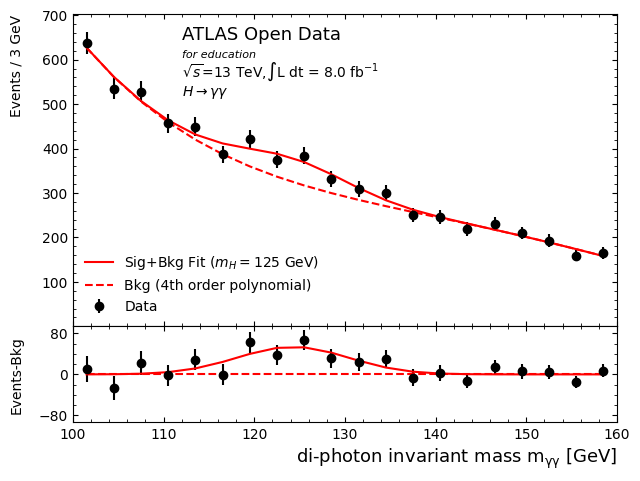

In [23]:
plot_data(df)